In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl
import matplotlib.patches as patches


coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
pdf = pkl.load(open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
box = np.array([1.5,2.5,7,8])
pdf_all = pdf.where((pdf.clat >= box[2]) & (pdf.clat <= box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & 
                    ((pdf.month >= 3) & (pdf.month <= 5)) | ((pdf.month >= 9) & (pdf.month <= 11)))
pdf_all = pdf_all.dropna()

pdf_march = pdf.where((pdf.clat >= box[2]) & (pdf.clat <= box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & (pdf.month == 3))
pdf_march = pdf_march.dropna()

pdf_oct = pdf.where((pdf.clat >= box[2]) & (pdf.clat <=box[3]) & (pdf.clon >= box[0]) & (pdf.clon <= box[1]) &
                        (pdf.year >= 2000) & (pdf.year <= 2014) & (pdf.month == 10))
pdf_oct = pdf_oct.dropna()

In [4]:
pdf_all.keys()

Index(['date', 'month', 'year', 'area', '70area', 'minlon', 'minlat', 'maxlon',
       'maxlat', 'clon', 'clat', 'tmin', 'tmean', 't10', 't90'],
      dtype='object')

In [5]:
len(pdf_march)

32

In [6]:
dates_all = pdf_all.date
dates_mar = pdf_march.date
dates_oct = pdf_oct.date

In [7]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 10

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [71]:
def run(shift, hour,tab,ibox):
    dic = {
    'q' : [],
    't' : [],
    'u' : [],
    'v' : [],
    'w' : [],
    'u_orig' : [],
    'v_orig' : [],        
    'w_orig' : [],  
    'd' : [],
    't2' : [],
    'u100' : [],
    'v100' : [],
    'u100_orig' : [],
    'v100_orig' : [],
    'slp' : [],
    'cnt' : [],
    'mcc' : [],
    'hcc' : [],
    'cape' : [],
    'divMoist' : [],
    'ice' : [],
    'ice_orig' : [],
    'sh' : [],
    'rh' : [],
    'zshear' : []
    }
    
    clim = '/home/ck/DIR/mymachine/ERA5/monthly/synop_selfmade/CLIM_2000-2014/'
    
    #box = [-4.5,3.5,9,15] #ouaga
    box = [-7.5,7.5,4,11] # WA



    for date in tab:


        single = tab[tab==date]
       
        dt = pd.to_datetime(date)
        
        
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('7days')
        window2 = dt + pd.Timedelta('7days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = hour
        shour = hour

        try:

            lsta = xr.open_dataset(cnst.ERA5 + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            lsta_clim = xr.open_dataset(clim + \
                            'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(cnst.ERA5 + 'hourly/surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
            srfc_clim = xr.open_dataset(clim + \
                            'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(ibox[0], ibox[1]), latitude=slice(box[2],box[3])).mean('longitude')
        lsta_clim = lsta_clim.sel(lon=slice(ibox[0], ibox[1]), lat=slice(box[2],box[3])).mean('lon')
        
        srfc = srfc.sel(longitude=slice(ibox[0], ibox[1]), latitude=slice(box[2],box[3])).mean('longitude')
        srfc_clim = srfc_clim.sel(lon=slice(ibox[0], ibox[1]), lat=slice(box[2],box[3])).mean('lon')
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
        

        
#         lsta10_low = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=925)
        
#         lsta10_up = lsta10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00', level=650)
        
        
        
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     
        
#         srfc10 = srfc.isel(time=pos[0])
#         srfc10 = srfc10.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(shour).zfill(2)+':00:00' )
     
        
        
        
        lsta_clim_low = lsta_clim
        
        #ipdb.set_trace()

        q = lsta_low['q'].squeeze()
        u = lsta_low['u'].squeeze()
        v = lsta_low['v'].squeeze()
        w = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        u100 = srfc_low['u10'].squeeze()
        v100 = srfc_low['v10'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        hcc = srfc_low['hcc'].squeeze()
        mcc = srfc_low['mcc'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        ice = srfc_low['tciw'].squeeze()
        sh = srfc_low['ishf'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        u_clim = lsta10_low['u'].squeeze().mean('time')
        v_clim = lsta10_low['v'].squeeze().mean('time')
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        u100_clim = srfc10['u10'].squeeze().mean('time')
        v100_clim = srfc10['v10'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cape_clim = srfc10['cape'].squeeze().mean('time')
        hcc_clim = srfc10['hcc'].squeeze().mean('time')
        mcc_clim = srfc10['mcc'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        ice_clim = srfc10['tciw'].squeeze().mean('time')
        sh_clim = srfc10['ishf'].squeeze().mean('time')
        
#         q_clim = lsta10_low['q'].squeeze()
#         u_clim = lsta10_up['u'].squeeze()
#         v_clim = lsta10_up['v'].squeeze()
#         w_clim = lsta10_low['w'].squeeze()
#         t_clim = lsta10_low['t'].squeeze()
#         rh_clim = lsta10_low['r'].squeeze()
#         d_clim = lsta10_low['d'].squeeze()
#         t2_clim = srfc10['t2m'].squeeze()
#         u100_clim = srfc10['u100'].squeeze()
#         v100_clim = srfc10['v100'].squeeze()
#         slp_clim = srfc10['sp'].squeeze()
#         cape_clim = srfc10['cape'].squeeze()
#         hcc_clim = srfc10['hcc'].squeeze()
#         mcc_clim = srfc10['mcc'].squeeze()
#         divMoist_clim = srfc10['p84.162']
#         ice_clim = srfc10['tciw'].squeeze()
#         sh_clim = srfc10['ishf'].squeeze()

#         q_clim = lsta_clim_low['q'].squeeze()
#         u_clim = lsta_clim_up['u'].squeeze()
#         v_clim = lsta_clim_up['v'].squeeze()
#         t_clim = lsta_clim_low['t'].squeeze()
#         d_clim = lsta_clim_low['d'].squeeze()
#         t2_clim = srfc_clim['t2m'].squeeze()
#         u100_clim = srfc_clim['u100'].squeeze()
#         v100_clim = srfc_clim['v100'].squeeze()
#         slp_clim = srfc_clim['msl'].squeeze()

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')

        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q'].append(q.values- q_clim.values)
        dic['v'].append(v.values- v_clim.values)
        dic['w'].append(w.values- w_clim.values)
        dic['u'].append(u.values- u_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['v_orig'].append(v.values)#
        dic['u_orig'].append(u.values)#
        dic['w_orig'].append(w.values)#
        dic['t'].append(t.values-t_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['u100'].append(u100.values-u100_clim.values)
        dic['v100'].append(v100.values-v100_clim.values)
        dic['u100_orig'].append(u100.values)#
        dic['v100_orig'].append(v100.values)#
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['hcc'].append(hcc.values-hcc_clim.values)
        dic['mcc'].append(mcc.values-mcc_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['ice'].append(ice.values-ice_clim.values)
        dic['ice_orig'].append(ice.values)
        dic['sh'].append(sh.values-sh_clim.values)
        ws, wd = u_met.u_v_to_ws_wd(u.values-u100.values, v.values-v100.values)
        wsclim, wd = u_met.u_v_to_ws_wd(u_clim.values-u100_clim.values, v_clim.values-v100_clim.values)
        dic['zshear'].append(ws-wsclim)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        level = lsta.level.values
    
    for k in dic.keys():
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, level

In [72]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [84]:
dic, lat, level = run(0,12,dates_mar, box)
dic = calc(dic)

Doing AMSR_20000319.nc
Doing AMSR_20010315.nc
Doing AMSR_20010328.nc
Doing AMSR_20010328.nc
Doing AMSR_20020315.nc
Doing AMSR_20020323.nc
Doing AMSR_20030308.nc
Doing AMSR_20040301.nc
Doing AMSR_20040327.nc
Doing AMSR_20060303.nc
Doing AMSR_20060313.nc
Doing AMSR_20060325.nc
Doing AMSR_20070316.nc
Doing AMSR_20080308.nc
Doing AMSR_20080317.nc
Doing AMSR_20080320.nc
Doing AMSR_20080328.nc
Doing AMSR_20090314.nc
Doing AMSR_20090319.nc
Doing AMSR_20090325.nc
Doing AMSR_20100301.nc
Doing AMSR_20100304.nc
Doing AMSR_20100312.nc
Doing AMSR_20100314.nc
Doing AMSR_20110316.nc
Doing AMSR_20110317.nc
Doing AMSR_20110328.nc
Doing AMSR_20130307.nc
Doing AMSR_20130308.nc
Doing AMSR_20140310.nc
Doing AMSR_20140323.nc
Doing AMSR_20140325.nc


In [85]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

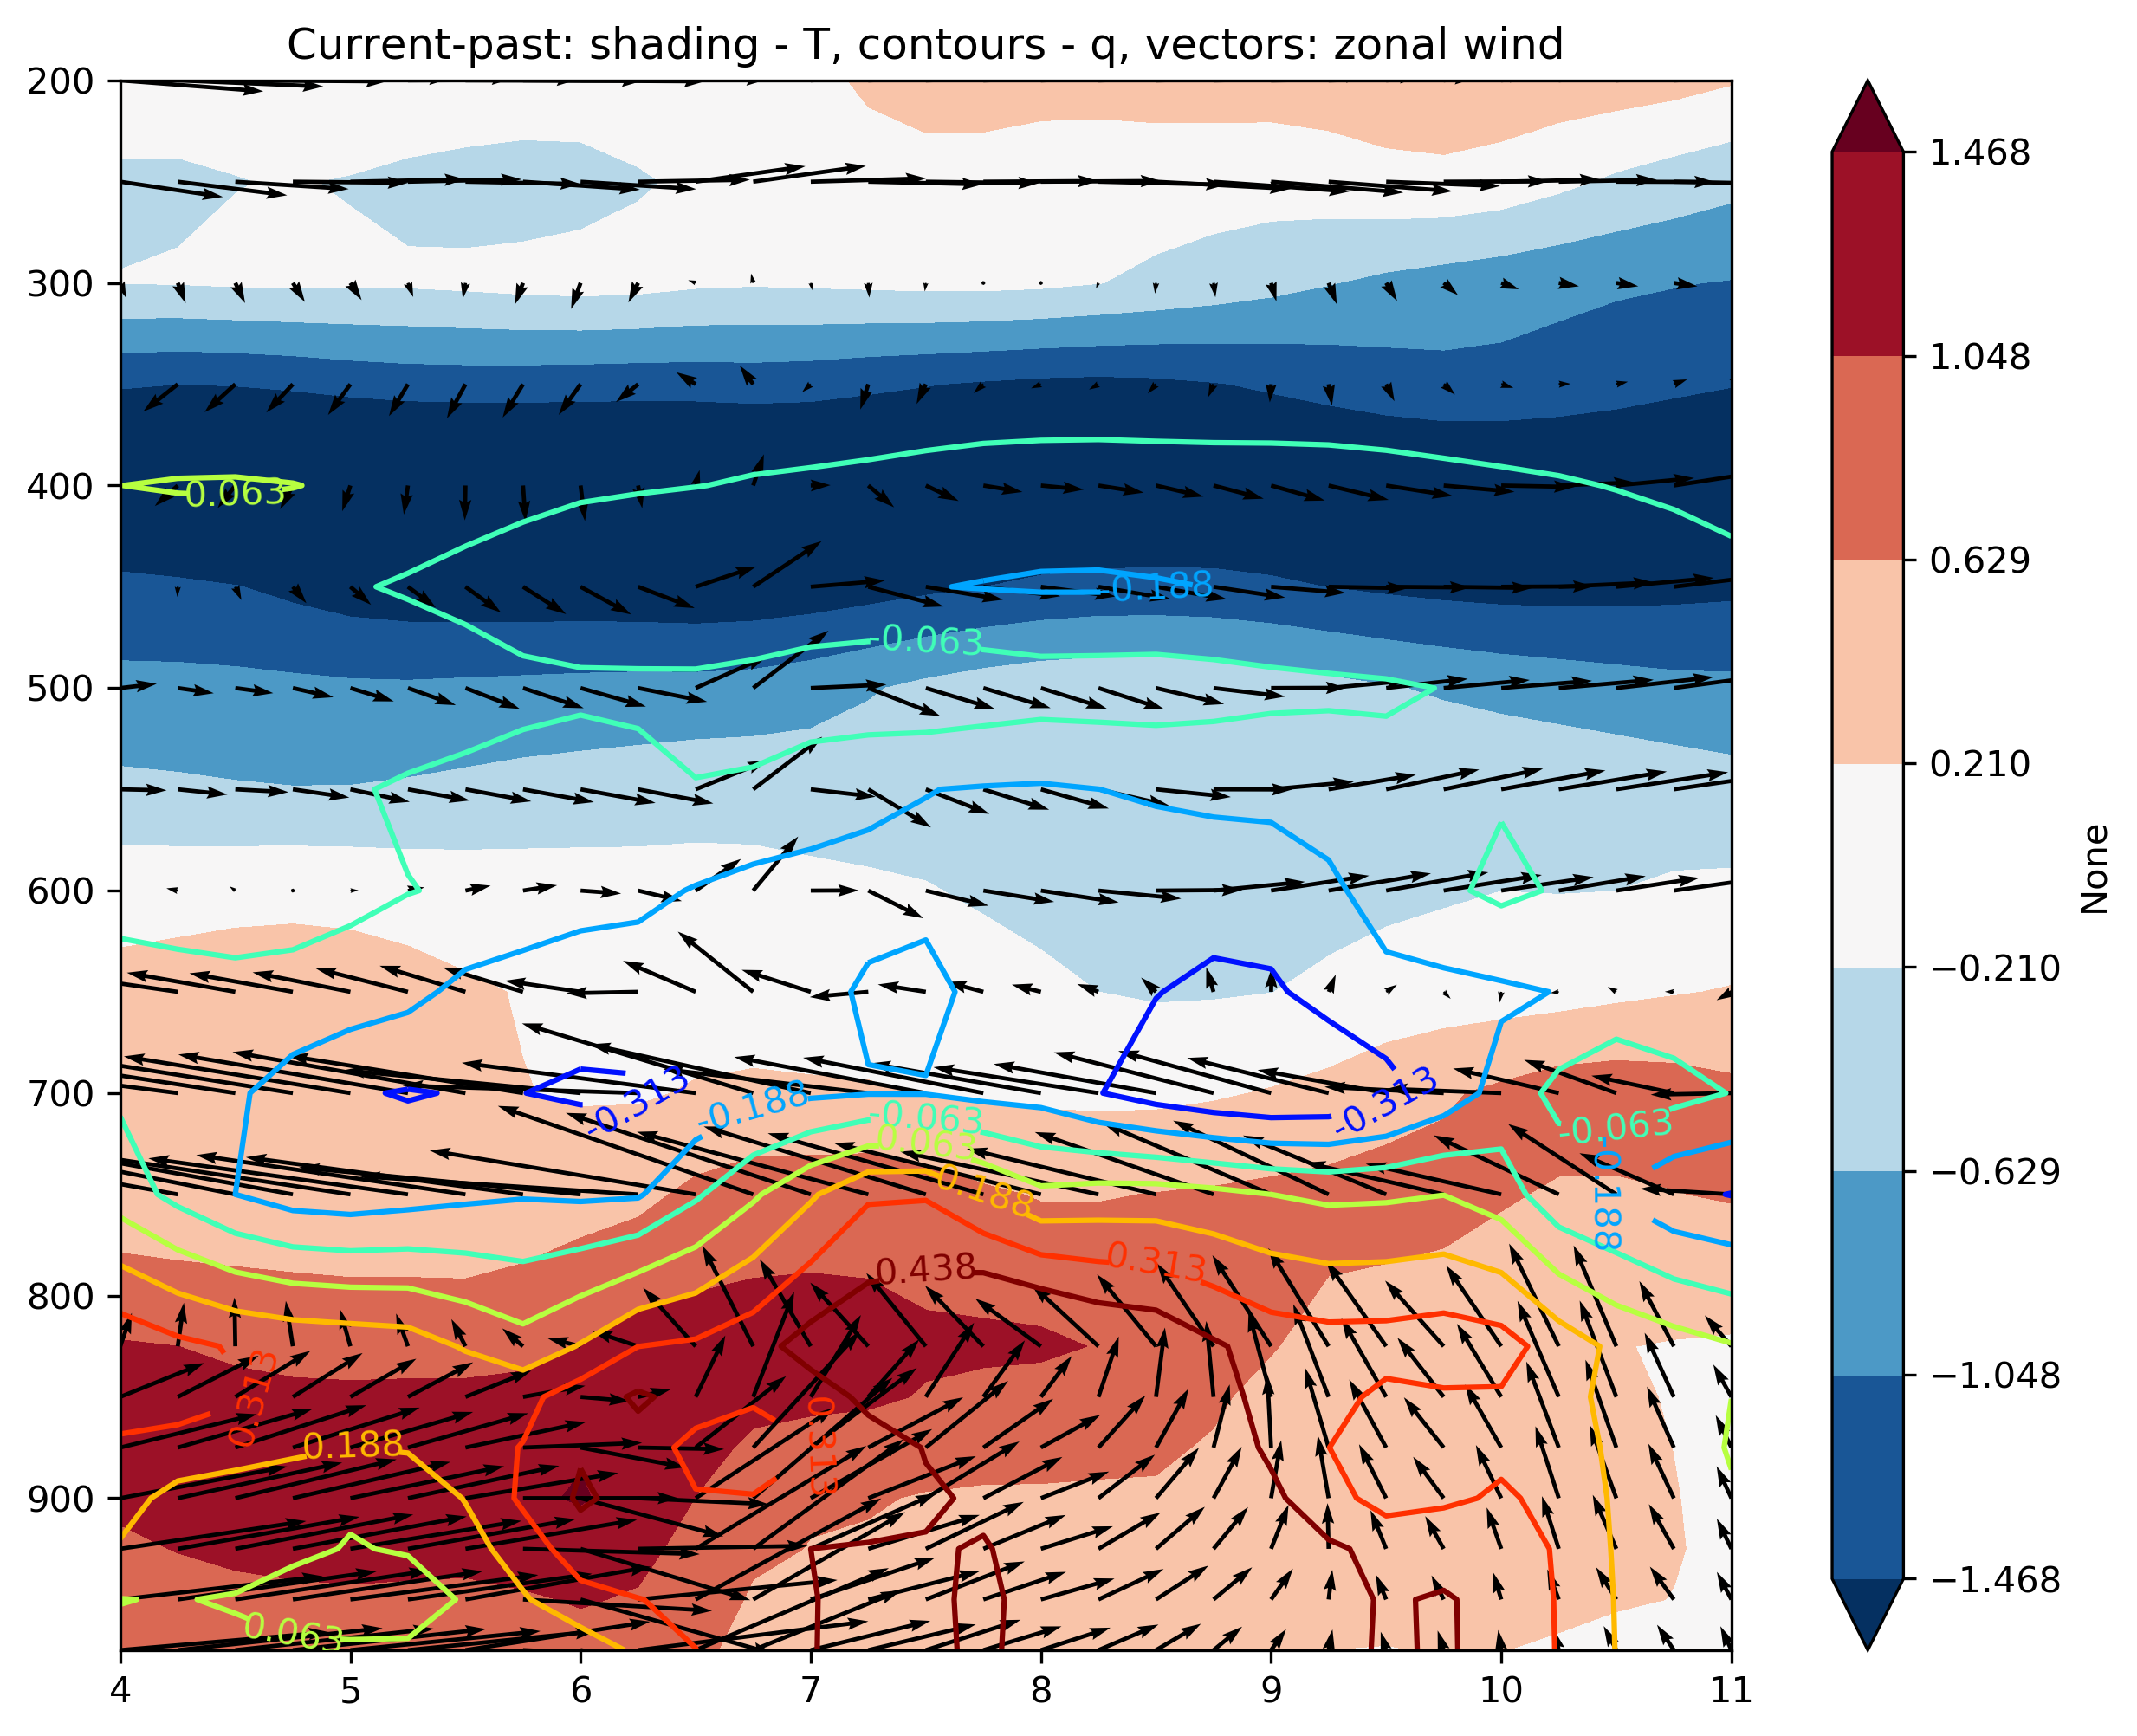

In [86]:
f = plt.figure(figsize=(10,8), dpi=300)
ax = f.add_subplot(111)
# "current zonal wind" wind vectors
vano = dic['v_orig']
wano = dic['w_orig']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1


lat2d, lev2d = np.meshgrid(lat,level)

xquiv = lat#[sarrow::st, sarrow::st]
yquiv = level#[sarrow::st, sarrow::st]

uu = (vano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

# temperature and moisture check
var = dic['u']
cvar = dic['q']*1000
edge = np.max([np.abs(np.percentile(cvar,10)),np.abs(np.percentile(cvar,90))])
levs = np.linspace(edge*-1,edge,8)

edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
#edge = 20
lev = np.linspace(edge*-1,edge,8) # 

contour = {'data' : cvar, 'x' : lat, 'y' : level, 'levels' : levs, 'cmap' : 'jet'}
draw_cross(ax, var, lat, level, cmap='RdBu_r', levels=lev,
            quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

-3
Doing AMSR_20000316.nc
Doing AMSR_20010312.nc
Doing AMSR_20010325.nc
Doing AMSR_20010325.nc
Doing AMSR_20020312.nc
Doing AMSR_20020320.nc
Doing AMSR_20030305.nc
Doing AMSR_20040227.nc
Doing AMSR_20040324.nc
Doing AMSR_20060228.nc
Doing AMSR_20060310.nc
Doing AMSR_20060322.nc
Doing AMSR_20070313.nc
Doing AMSR_20080305.nc
Doing AMSR_20080314.nc
Doing AMSR_20080317.nc
Doing AMSR_20080325.nc
Doing AMSR_20090311.nc
Doing AMSR_20090316.nc
Doing AMSR_20090322.nc
Doing AMSR_20100226.nc
Doing AMSR_20100301.nc
Doing AMSR_20100309.nc
Doing AMSR_20100311.nc
Doing AMSR_20110313.nc
Doing AMSR_20110314.nc
Doing AMSR_20110325.nc
Doing AMSR_20130304.nc
Doing AMSR_20130305.nc
Doing AMSR_20140307.nc
Doing AMSR_20140320.nc
Doing AMSR_20140322.nc
-2


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:229: RuntimeWarning: invalid value encountered in greater
  or (np.ptp(linecontour, axis=0) > 1.2 * labelwidth).any())


Doing AMSR_20000317.nc
Doing AMSR_20010313.nc
Doing AMSR_20010326.nc
Doing AMSR_20010326.nc
Doing AMSR_20020313.nc
Doing AMSR_20020321.nc
Doing AMSR_20030306.nc
Doing AMSR_20040228.nc
Doing AMSR_20040325.nc
Doing AMSR_20060301.nc
Doing AMSR_20060311.nc
Doing AMSR_20060323.nc
Doing AMSR_20070314.nc
Doing AMSR_20080306.nc
Doing AMSR_20080315.nc
Doing AMSR_20080318.nc
Doing AMSR_20080326.nc
Doing AMSR_20090312.nc
Doing AMSR_20090317.nc
Doing AMSR_20090323.nc
Doing AMSR_20100227.nc
Doing AMSR_20100302.nc
Doing AMSR_20100310.nc
Doing AMSR_20100312.nc
Doing AMSR_20110314.nc
Doing AMSR_20110315.nc
Doing AMSR_20110326.nc
Doing AMSR_20130305.nc
Doing AMSR_20130306.nc
Doing AMSR_20140308.nc
Doing AMSR_20140321.nc
Doing AMSR_20140323.nc
-1


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:229: RuntimeWarning: invalid value encountered in greater
  or (np.ptp(linecontour, axis=0) > 1.2 * labelwidth).any())


Doing AMSR_20000318.nc
Doing AMSR_20010314.nc
Doing AMSR_20010327.nc
Doing AMSR_20010327.nc
Doing AMSR_20020314.nc
Doing AMSR_20020322.nc
Doing AMSR_20030307.nc
Doing AMSR_20040229.nc
Doing AMSR_20040326.nc
Doing AMSR_20060302.nc
Doing AMSR_20060312.nc
Doing AMSR_20060324.nc
Doing AMSR_20070315.nc
Doing AMSR_20080307.nc
Doing AMSR_20080316.nc
Doing AMSR_20080319.nc
Doing AMSR_20080327.nc
Doing AMSR_20090313.nc
Doing AMSR_20090318.nc
Doing AMSR_20090324.nc
Doing AMSR_20100228.nc
Doing AMSR_20100303.nc
Doing AMSR_20100311.nc
Doing AMSR_20100313.nc
Doing AMSR_20110315.nc
Doing AMSR_20110316.nc
Doing AMSR_20110327.nc
Doing AMSR_20130306.nc
Doing AMSR_20130307.nc
Doing AMSR_20140309.nc
Doing AMSR_20140322.nc
Doing AMSR_20140324.nc
0


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:229: RuntimeWarning: invalid value encountered in greater
  or (np.ptp(linecontour, axis=0) > 1.2 * labelwidth).any())


Doing AMSR_20000319.nc
Doing AMSR_20010315.nc
Doing AMSR_20010328.nc
Doing AMSR_20010328.nc
Doing AMSR_20020315.nc
Doing AMSR_20020323.nc
Doing AMSR_20030308.nc
Doing AMSR_20040301.nc
Doing AMSR_20040327.nc
Doing AMSR_20060303.nc
Doing AMSR_20060313.nc
Doing AMSR_20060325.nc
Doing AMSR_20070316.nc
Doing AMSR_20080308.nc
Doing AMSR_20080317.nc
Doing AMSR_20080320.nc
Doing AMSR_20080328.nc
Doing AMSR_20090314.nc
Doing AMSR_20090319.nc
Doing AMSR_20090325.nc
Doing AMSR_20100301.nc
Doing AMSR_20100304.nc
Doing AMSR_20100312.nc
Doing AMSR_20100314.nc
Doing AMSR_20110316.nc
Doing AMSR_20110317.nc
Doing AMSR_20110328.nc
Doing AMSR_20130307.nc
Doing AMSR_20130308.nc
Doing AMSR_20140310.nc
Doing AMSR_20140323.nc
Doing AMSR_20140325.nc
1


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:229: RuntimeWarning: invalid value encountered in greater
  or (np.ptp(linecontour, axis=0) > 1.2 * labelwidth).any())


Doing AMSR_20000320.nc
Doing AMSR_20010316.nc
Doing AMSR_20010329.nc
Doing AMSR_20010329.nc
Doing AMSR_20020316.nc
Doing AMSR_20020324.nc
Doing AMSR_20030309.nc
Doing AMSR_20040302.nc
Doing AMSR_20040328.nc
Doing AMSR_20060304.nc
Doing AMSR_20060314.nc
Doing AMSR_20060326.nc
Doing AMSR_20070317.nc
Doing AMSR_20080309.nc
Doing AMSR_20080318.nc
Doing AMSR_20080321.nc
Doing AMSR_20080329.nc
Doing AMSR_20090315.nc
Doing AMSR_20090320.nc
Doing AMSR_20090326.nc
Doing AMSR_20100302.nc
Doing AMSR_20100305.nc
Doing AMSR_20100313.nc
Doing AMSR_20100315.nc
Doing AMSR_20110317.nc
Doing AMSR_20110318.nc
Doing AMSR_20110329.nc
Doing AMSR_20130308.nc
Doing AMSR_20130309.nc
Doing AMSR_20140311.nc
Doing AMSR_20140324.nc
Doing AMSR_20140326.nc
2


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:229: RuntimeWarning: invalid value encountered in greater
  or (np.ptp(linecontour, axis=0) > 1.2 * labelwidth).any())


Doing AMSR_20000321.nc
Doing AMSR_20010317.nc
Doing AMSR_20010330.nc
Doing AMSR_20010330.nc
Doing AMSR_20020317.nc
Doing AMSR_20020325.nc
Doing AMSR_20030310.nc
Doing AMSR_20040303.nc
Doing AMSR_20040329.nc
Doing AMSR_20060305.nc
Doing AMSR_20060315.nc
Doing AMSR_20060327.nc
Doing AMSR_20070318.nc
Doing AMSR_20080310.nc
Doing AMSR_20080319.nc
Doing AMSR_20080322.nc
Doing AMSR_20080330.nc
Doing AMSR_20090316.nc
Doing AMSR_20090321.nc
Doing AMSR_20090327.nc
Doing AMSR_20100303.nc
Doing AMSR_20100306.nc
Doing AMSR_20100314.nc
Doing AMSR_20100316.nc
Doing AMSR_20110318.nc
Doing AMSR_20110319.nc
Doing AMSR_20110330.nc
Doing AMSR_20130309.nc
Doing AMSR_20130310.nc
Doing AMSR_20140312.nc
Doing AMSR_20140325.nc
Doing AMSR_20140327.nc


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in reduce
  umr_maximum(a, axis, None, out, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in reduce
  umr_minimum(a, axis, None, None, keepdims),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:229: RuntimeWarning: invalid value encountered in greater
  or (np.ptp(linecontour, axis=0) > 1.2 * labelwidth).any())


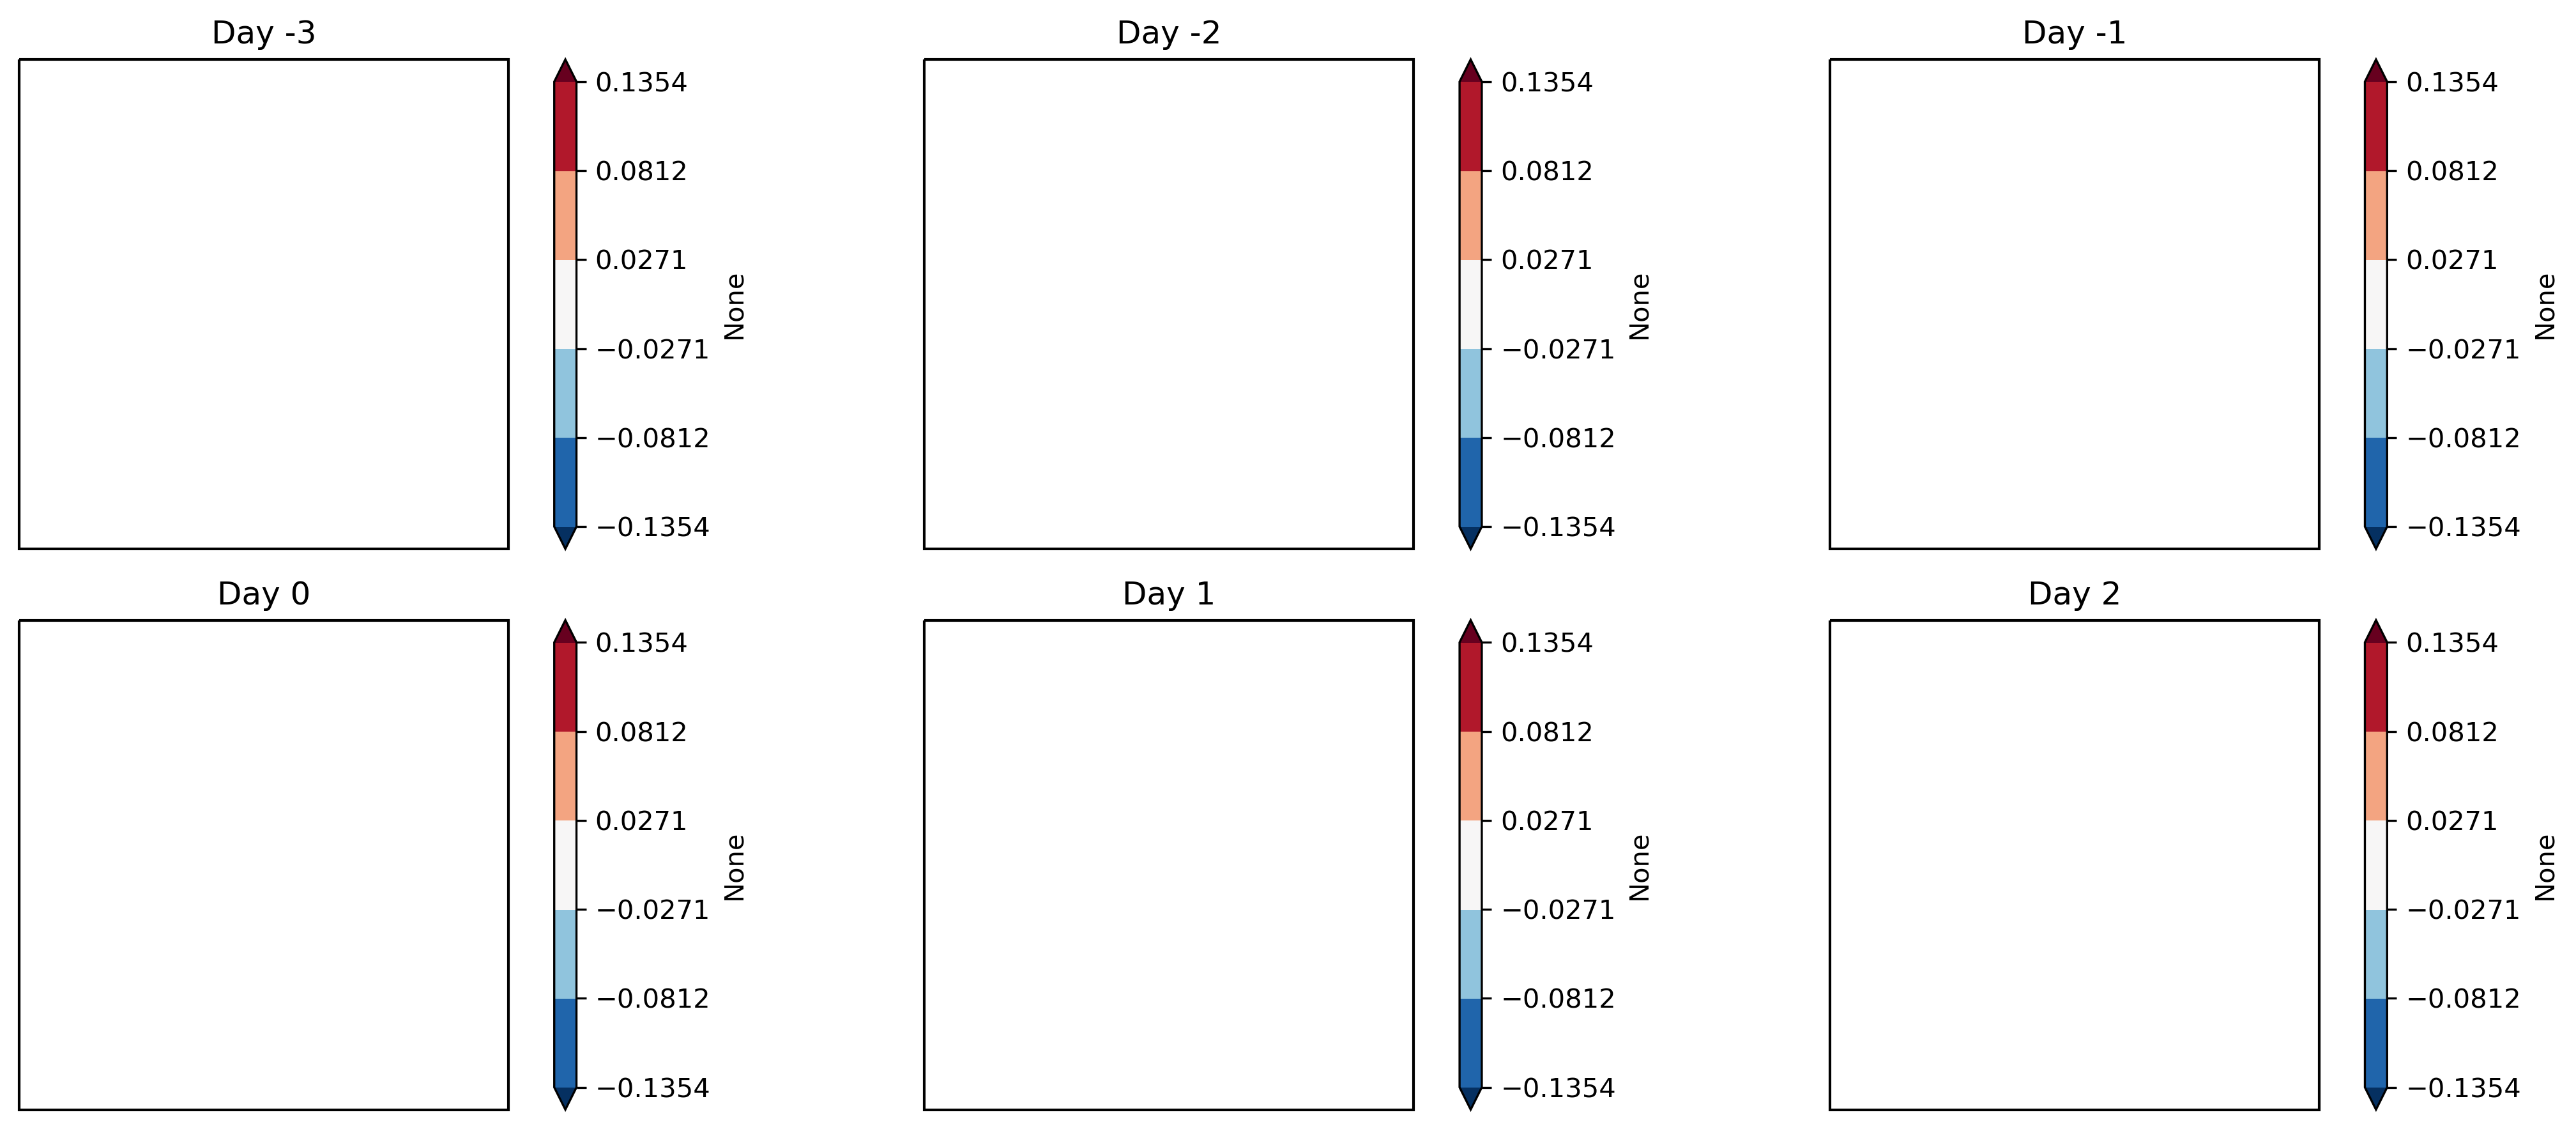

In [82]:
tab = dates_mar
st=2
sarrow = 2
scale = 30
vano = 'v_orig'
wano = 'w_orig'
hour=12
f = plt.figure(figsize=(15,6), dpi=300)

for ids, num in enumerate([-3,-2,-1,0,1,2]):

    ax = f.add_subplot(2,3,ids+1, projection=ccrs.PlateCarree())
    print(num)
    
    dic, lat, lon = run(num, hour, tab,box)
    dic = calc(dic)
    
    if ids == 0:
        lat2d, lev2d = np.meshgrid(lat,level)

        xquiv = lat2d[sarrow::st, sarrow::st]
        yquiv = lev2d[sarrow::st, sarrow::st]


    #ipdb.set_trace()
    
    var = dic['t']
    
    if ids == 0:
        edge = np.max([np.abs(np.percentile(var,10)),np.abs(np.percentile(var,90))])
        lev = np.linspace(edge*-1,edge,6) # edge*-1

    u = dic[utag]
    v = dic[vtag]

    uu = (dic[vano])#[::, sarrow::st]  
    ww = (dic[wano]*-10)#[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}
    
    
    cvar = 'q'
    invar = dic[cvar]
    if ids == 0:
        edge = np.max([np.abs(np.percentile(invar,10)),np.abs(np.percentile(invar,90))])
        levs = np.linspace(edge*-1,edge,6) # edge*-1
    contour = {'data' : invar, 'x' : lat, 'y' : level, 'levels' : levs, 'cmap' : 'jet'}
    
    draw_cross(ax, var, lat, level, cmap='RdBu_r', title='Day '+str(num),  quiver=qin, levels=lev, contour=contour)  #levels=lev,

f.canvas.draw()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/CLOVER/composites/cross_t_q_march_12UTC.png')

## 